# 02 — Exploratory Data Analysis (EDA): Telco Customer Churn

## 1. Objective of Exploratory Data Analysis
The goal of this EDA is to:
- Understand the structure and quality of the data
- Identify key variables related to customer churn
- Detect patterns, trends, and potential segmentation signals
- Prepare the dataset for modeling in later notebooks

In [15]:
import pandas as pd
import numpy as np

# Display settings
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

## 2. Data Loading and Initial Setup

In this section, we import required Python libraries and load the dataset
to begin exploratory analysis.

In [23]:
df = pd.read_csv("data/telco_customer_churn.csv")
df.shape
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## 3. Initial Data Inspection

In [26]:
# 3.1 Check unique values in TotalCharges
df["TotalCharges"].unique()[:10]

# 3.2 Convert TotalCharges to numeric
# Non-numeric values (e.g., blank strings) will be coerced to NaN
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# 3.3 Check missing values
missing_summary = df.isna().sum()
missing_summary

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

### Data Quality Findings

The dataset is largely complete, with no missing values across most variables.
The only exception is the `TotalCharges` column, which contains 11 missing values.

Upon inspection, these missing values correspond to customers with a tenure of 0 months.
This is expected, as new customers have not yet accumulated any total charges.

Therefore, the missingness in `TotalCharges` is business-driven and not indicative of data quality issues.

## 4. Target Variable Understanding: Customer Churn

Before building any predictive models, it is critical to understand the behavior
and distribution of the target variable — `Churn`.

In this section, we:
- Examine the overall churn rate
- Assess class imbalance
- Discuss implications for modeling and evaluation strategies

In [30]:
# Check unique values of Churn
df["Churn"].value_counts()

churn_rate = df["Churn"].value_counts(normalize=True) * 100
churn_rate

Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64

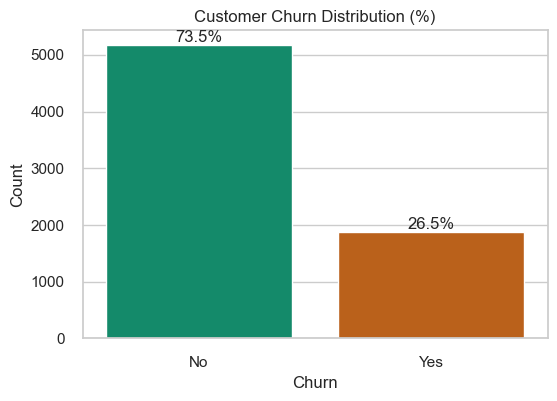

In [55]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(
    x="Churn",
    data=df,
    hue="Churn",
    palette={"No": "#009E73", "Yes": "#D55E00"},
    legend=False
)
total = len(df)
for p in ax.patches:
    percentage = f"{100 * p.get_height() / total:.1f}%"
    ax.annotate(
        percentage,
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha="center",
        va="bottom"
    )

plt.title("Customer Churn Distribution (%)")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()

### Key Observations

- Approximately **26.5% of customers have churned**, indicating a non-trivial retention problem.
- The dataset is **moderately imbalanced**, with the majority class being non-churn customers.
- This level of imbalance is common in real-world customer retention problems and should be considered in model evaluation.

## 5. Churn Drivers Analysis

The goal of this section is to identify **key factors associated with customer churn**.
We focus on variables that are actionable from a business perspective and commonly
used in customer retention modeling.

We begin with **tenure**, one of the strongest and most interpretable predictors of churn.

In [62]:
# Compare average tenure for churned vs non-churned customers
df.groupby("Churn")["tenure"].describe()

,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
No,5174.0,37.569965,24.113777,0.0,15.0,38.0,61.0,72.0
Yes,1869.0,17.979133,19.531123,1.0,2.0,10.0,29.0,72.0


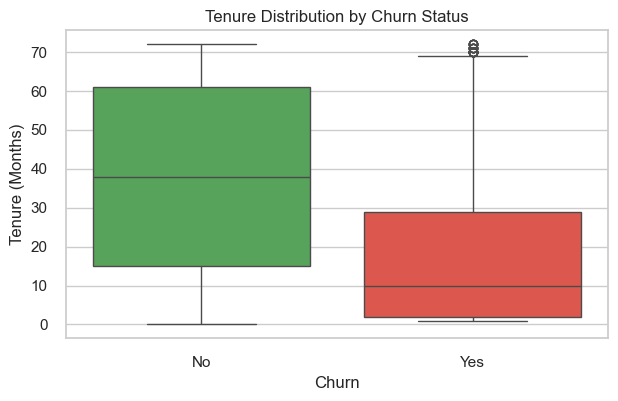

In [48]:
plt.figure(figsize=(7, 4))
sns.boxplot(
    x="Churn",
    y="tenure",
    hue="Churn",
    data=df,
    palette={"No": "#4CAF50", "Yes": "#F44336"},
    dodge=False
)

plt.title("Tenure Distribution by Churn Status")
plt.xlabel("Churn")
plt.ylabel("Tenure (Months)")
plt.legend([],[], frameon=False)
plt.show()

In [50]:
# Churn rate by contract type
contract_churn = (
    df.groupby("Contract")["Churn"]
      .value_counts(normalize=True)
      .rename("proportion")
      .reset_index()
)

contract_churn

,Contract,Churn,proportion
0,Month-to-month,No,0.572903
1,Month-to-month,Yes,0.427097
2,One year,No,0.887305
3,One year,Yes,0.112695
4,Two year,No,0.971681
5,Two year,Yes,0.028319


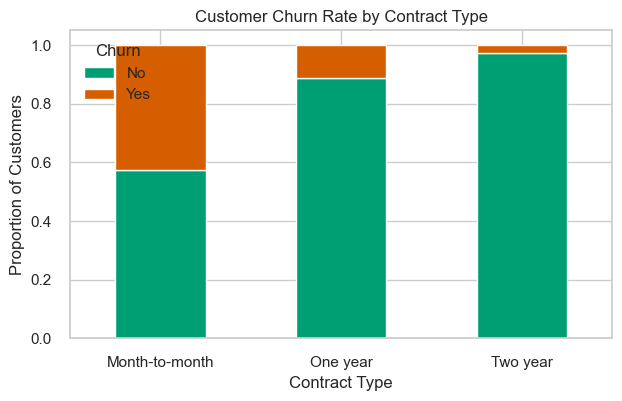

In [57]:
# Prepare data for visualization
contract_pivot = contract_churn.pivot(
    index="Contract",
    columns="Churn",
    values="proportion"
)

# Plot
contract_pivot.plot(
    kind="bar",
    stacked=True,
    figsize=(7, 4),
    color=["#009E73", "#D55E00"]
)

plt.title("Customer Churn Rate by Contract Type")
plt.xlabel("Contract Type")
plt.ylabel("Proportion of Customers")
plt.legend(title="Churn")
plt.xticks(rotation=0)
plt.show()

### Key Insight: Contract Length and Customer Churn

Contract length shows a strong and consistent relationship with customer churn.

- Month-to-month customers exhibit the highest churn rate (approximately 43%), indicating high volatility and low commitment.
- One-year contract customers show a significantly reduced churn rate (~11%).
- Two-year contract customers demonstrate extremely low churn (<3%), suggesting strong retention.

This pattern indicates that contract duration is a critical, actionable lever for churn reduction. 
Encouraging customers to move from month-to-month plans to longer-term contracts could materially improve customer retention and lifetime value.

In [64]:
# Compare MonthlyCharges for churned vs non-churned customers
df.groupby("Churn")["MonthlyCharges"].describe()

,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
No,5174.0,61.265124,31.092648,18.25,25.10,64.425,88.4,118.75
Yes,1869.0,74.441332,24.666053,18.85,56.15,79.650,94.2,118.35


/var/folders/qb/3bgllfjn4zd4kmmhn7wj94zw0000gn/T/ipykernel_75774/942838031.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


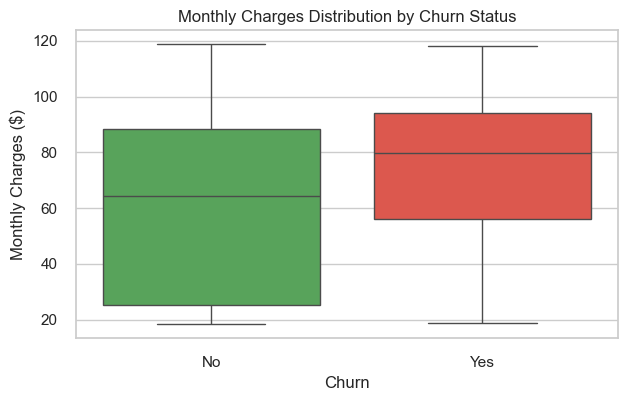

In [66]:
plt.figure(figsize=(7, 4))
sns.boxplot(
    x="Churn",
    y="MonthlyCharges",
    data=df,
    palette={"No": "#4CAF50", "Yes": "#F44336"}
)

plt.title("Monthly Charges Distribution by Churn Status")
plt.xlabel("Churn")
plt.ylabel("Monthly Charges ($)")
plt.show()

### 5.4 Summary of Key Churn Drivers

Based on exploratory analysis, the following variables show strong association with customer churn:

- **Tenure**: Customers with shorter tenure are significantly more likely to churn, indicating early-stage customer experience is critical.
- **Contract Type**: Month-to-month contracts exhibit substantially higher churn rates compared to one-year and two-year contracts, suggesting contract commitment plays a key retention role.
- **Monthly Charges**: Churned customers tend to have higher monthly charges, implying price sensitivity and perceived value may influence churn behavior.

These findings motivate the inclusion of tenure, contract type, and pricing-related features in downstream predictive models.